In [1]:
import numpy as np
import pandas as pd
import preprocessing as pp
import tensorflow as tf
import preprocessing as pp
import matplotlib.pyplot as plt
import confusion_matrix as cmat

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
np.random.seed(1313)
tf.random.set_seed(1313)

In [4]:
X, y, X_columns, y_columns = pp.load_data(suffix='_goal_difference_full_features')

In [2]:
X, y, X_columns, y_columns = pp.preprocess(include=['danger', 'zones'], return_arrays=True, save_as_file=True, y_goal_diff=True, 
                                            suffix='_goal_difference_full_features')

In [5]:
classes = list(map(str, list(y_columns.keys())))

In [6]:
print(X.shape)
print(y.shape)

print(list(X_columns.keys()))
print(list(y_columns.keys()))

(11244, 366, 17)
(11244, 7)
['game_id', 'event_blocked_shot', 'event_faceoff', 'event_giveaway', 'event_hit', 'event_missed_shot', 'event_penalty', 'event_shot', 'event_takeaway', 'danger_a_high', 'danger_b_med', 'danger_c_low', 'danger_d_not_a_shot', 'event_dummy', 'home_team_for', 'offensive_zone_home', 'offensive_zone_away']
['-3', '-2', '-1', '0', '1', '2', '3']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X[:,:,1:], y, test_size=0.25)

In [8]:
# data = {'Goals': tuple(X[:,:,-1]), 'Result': y[:,0]}
# df = pd.DataFrame(data, columns=['Goals', 'Result'])
# pd.crosstab(df['Goals'].astype(str), df['Result'])

In [9]:
print(np.isnan(X).any())

False


In [10]:
data_shape = tuple(X_train.shape[1:])
print(data_shape)

(366, 16)


In [11]:
print(np.sum(y_train, axis=0))
print(np.sum(y_test, axis=0))

[1128  825  874 1982 1020  951 1653]
[376 270 329 674 328 323 511]


In [12]:
model_mlp = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu', input_shape=data_shape)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')),
    # tf.keras.layers.Dense(16, activation='relu'),
    # tf.keras.layers.Dense(8, activation='relu'),
    # tf.keras.layers.AveragePooling1D(16),
    # tf.keras.layers.Conv1D(64, 8, activation='relu'),
    # tf.keras.layers.Conv1D(32, 8, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

In [13]:
# optimizer = tf.keras.optimizers.RMSprop(lr=0.001)

model_mlp.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_mlp.fit(X_train, y_train, epochs=10, validation_split=0.25)
model_mlp.evaluate(X_test, y_test, verbose=0)

In [16]:
y_pred_mlp = model_mlp.predict(X_test)

In [13]:
for i in range(y_pred_mlp.shape[1]):
    print("Predicted goal difference " + str(list(y_columns.keys())[i]) + ":\t", np.sum(y_pred_mlp.argmax(axis=1) == i))

Predicted goal difference -3:	 314
Predicted goal difference -2:	 154
Predicted goal difference -1:	 280
Predicted goal difference 0:	 1033
Predicted goal difference 1:	 161
Predicted goal difference 2:	 195
Predicted goal difference 3:	 674


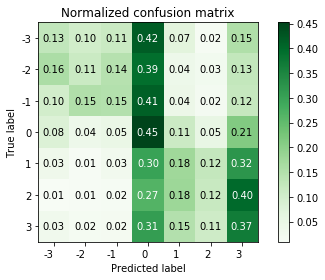

In [17]:
cmat.plot(y_test, y_pred_mlp, classes=list(y_columns.keys()), normalize=True)

plt.show()

In [49]:
print(classification_report(y_test.argmax(axis=1), y_pred_mlp.argmax(axis=1), target_names = classes))

              precision    recall  f1-score   support

          -3       0.21      0.26      0.23       376
          -2       0.18      0.15      0.16       270
          -1       0.22      0.26      0.24       329
           0       0.28      0.33      0.31       674
           1       0.17      0.14      0.16       328
           2       0.20      0.20      0.20       323
           3       0.29      0.20      0.24       511

    accuracy                           0.23      2811
   macro avg       0.22      0.22      0.22      2811
weighted avg       0.23      0.23      0.23      2811



In [19]:
model_conv1d = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 12, activation='relu', input_shape=data_shape),
    tf.keras.layers.Conv1D(64, 8, activation='relu'),
    tf.keras.layers.AveragePooling1D(3),
    tf.keras.layers.Conv1D(32, 6, activation='relu'),
    tf.keras.layers.Conv1D(32, 6, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])
model_conv1d.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model_conv1d.fit(X_train, y_train, epochs=10, validation_split=0.2)
model_conv1d.evaluate(X_test, y_test, verbose=2)

Train on 6746 samples, validate on 1687 samples
Epoch 1/10
6746/6746 [==============================] - 21s 3ms/sample - loss: 1.9069 - accuracy: 0.2244 - val_loss: 1.8729 - val_accuracy: 0.2620
Epoch 2/10
6746/6746 [==============================] - 21s 3ms/sample - loss: 1.8279 - accuracy: 0.2441 - val_loss: 1.6740 - val_accuracy: 0.2946
Epoch 3/10
6746/6746 [==============================] - 20s 3ms/sample - loss: 1.7381 - accuracy: 0.2671 - val_loss: 1.6560 - val_accuracy: 0.2851
Epoch 4/10
6746/6746 [==============================] - 21s 3ms/sample - loss: 1.7110 - accuracy: 0.2809 - val_loss: 1.6177 - val_accuracy: 0.3094
Epoch 5/10
6746/6746 [==============================] - 20s 3ms/sample - loss: 1.6729 - accuracy: 0.2942 - val_loss: 1.6239 - val_accuracy: 0.3059
Epoch 6/10
6746/6746 [==============================] - 21s 3ms/sample - loss: 1.6574 - accuracy: 0.2975 - val_loss: 1.5833 - val_accuracy: 0.3337
Epoch 7/10
6746/6746 [==============================] - 20s 3ms/sample

[1.58164199345988, 0.33155462]

In [21]:
y_pred_conv1d = model_conv1d.predict(X_test)

In [22]:
for i in range(y_pred_conv1d.shape[1]):
    print("Predicted goal difference " + str(list(y_columns.keys())[i]) + ":\t", np.sum(y_pred_conv1d.argmax(axis=1) == i))

Predicted goal difference -3:	 19
Predicted goal difference -2:	 38
Predicted goal difference -1:	 522
Predicted goal difference 0:	 985
Predicted goal difference 1:	 498
Predicted goal difference 2:	 0
Predicted goal difference 3:	 749


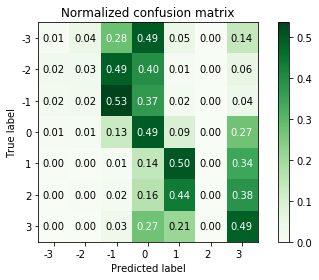

In [23]:
cmat.plot(y_test, y_pred_conv1d, classes=list(y_columns.keys()), normalize=True)

plt.show()

In [75]:
print(classification_report(y_test.argmax(axis=1), y_pred_conv1d.argmax(axis=1), target_names=classes))

              precision    recall  f1-score   support

          -3       0.11      0.01      0.01       376
          -2       0.18      0.03      0.05       270
          -1       0.34      0.53      0.41       329
           0       0.34      0.49      0.40       674
           1       0.33      0.50      0.40       328
           2       0.00      0.00      0.00       323
           3       0.33      0.49      0.40       511

    accuracy                           0.33      2811
   macro avg       0.23      0.29      0.24      2811
weighted avg       0.25      0.33      0.27      2811



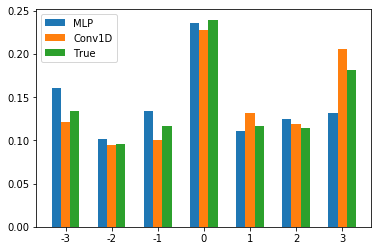

In [81]:
x = np.arange(len(classes)) 
width = 0.2

plt.bar(x - width, np.mean(y_pred_mlp, axis=0), width, label='MLP')
plt.bar(x, np.mean(y_pred_conv1d, axis=0), width, label='Conv1D')
plt.bar(x + width, np.mean(y_test, axis=0), width, label='True')

plt.legend(loc='upper left')
plt.xticks(x, classes)

plt.show()

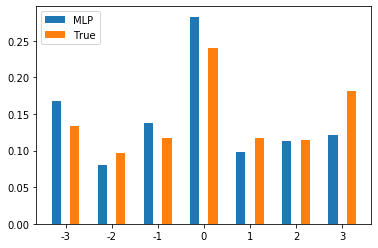

In [93]:
x = np.arange(len(classes)) 
width = 0.2

plt.bar(x - width, mlp_prop, width, label='MLP')
# plt.bar(x, conv1d_prop, width, label='Conv1D')
plt.bar(x + width, np.mean(y_test, axis=0), width, label='True')

plt.legend(loc='upper left')
plt.xticks(x, classes)

plt.show()